In [47]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
headers = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'collegeLevel', 'collegeScore', 'accepted']
header_type = [int, bool, bool,    bool,    bool,    bool,       bool,       float,  int,    float,       int,       float,      bool,   float,    int,               float,         int,              float,        bool]

n_extra_var = 7
n_latent_var = 7
for i in range(n_extra_var):
    headers.insert(-3,'var_'+str(i))

In [71]:
print(len(headers), len(header_type))

26 19


In [72]:
def latent_generator(inputs, outputs):
    coef_matrix = 2*(np.random.random((inputs,outputs)) - 0.5) # [-1,1]
    coef_matrix * np.random.random((inputs,outputs)) > 0.5
    def latent_mixer(x):
        return np.dot(x, coef_matrix)
    return latent_mixer

def good_latent_generator(inputs, outputs):
    while True:
        latent_gen = latent_generator(inputs,outputs)
        latent = []
        for _ in range(1000):
            latent.extend(latent_gen(np.random.random(inputs)))
        latent = np.array(latent)
        if np.abs(np.mean(latent)) < 0.1 and np.abs(np.quantile(latent, 0.05)) < 1 and np.abs(np.quantile(latent, 0.95)) < 1:
            return latent_gen

In [73]:
def collegeScore(person):
    # soft max score 1000
    score = 0
    applicant = {}
    for i in range(len(headers)):
        applicant[headers[i]] = person[i]
    if applicant['collegeLevel'] == 0:
        score += applicant['gpa']/4*250
        score += (applicant['SAT']-800)/800 * 50
        score += (applicant['SATWriting'])/8 * 50
        score += applicant['extracurriculars']/8 * 250
        score += applicant['essays'] * 300
        score += applicant['APTests']*applicant['APScores']/5*100
        if not applicant['white']:
            score *= 1.15

    if applicant['collegeLevel'] == 1:
        score += applicant['gpa']/4*250
        score += (applicant['SAT']-800)/800 * 150
        score += (applicant['SATWriting'])/8 * 100
        score += applicant['extracurriculars']/8 * 150
        score += applicant['essays'] * 200
        score += applicant['APTests']*applicant['APScores']/5*150
        if not applicant['white'] and not applicant['asian']:
            score *= 1.1

    if applicant['collegeLevel'] == 2:
        score += applicant['gpa']/4.5*200
        score += (applicant['SAT']-1200)/400 * 200
        score += (applicant['SATWriting']-4)/4 * 100
        score += applicant['extracurriculars']/8 * 100
        score += applicant['essays'] * 200
        score += applicant['APTests']*(applicant['APScores']-3)/2/10*200
        if applicant['gpa'] < 3.0:
            score = 0

    if applicant['collegeLevel'] == 3:
        score += 2**(3*(applicant['gpa']-5))*200
        score += 2**(3*(applicant['SAT']-1600)/100) * 150
        score += (applicant['SATWriting']-7) * 75
        score += 2**(1.7*(applicant['extracurriculars']/15-1)) * 175
        score += 2**(1.7*(applicant['essays']-1)) * 300
        score += applicant['APTests']*(applicant['APScores']-4)/10*100
        if applicant['gpa'] < 4.0 or (applicant['SAT'] < 1500 and applicant['STEM']):
            score = 0

    score = np.random.normal(score, 50, 1)[0]
    return score




In [162]:
def personGenerator(percentile, latent_gen):
    person = np.zeros(len(headers))
    age = random.randint(16,18)
    person[0] = age
    sex = random.randint(0,1)
    person[1] = sex
    race_index = np.random.choice([0,1,2,3,4], 1,
              p=[0.5, 0.2, 0.1, 0.1, 0.1]) + 2
    person[race_index] = 1

    extra_vars = np.random.random(n_extra_var)
    latent = latent_gen(extra_vars)

    gpa = -1
    SAT = -1
    SATWriting = -1
    APTests = -1
    APScores = -1
    STEM = -1
    essays= -1
    extracurriculars = -1
    collegeLevel = -1
    if percentile > 0.99:
        gpa = 4.0 + (percentile-0.98) * 100/2 * random.random() + 0.3 * latent[0]
        SAT = 1550 + round(min(50,(percentile-0.98) * 100 * random.random() * 50 + 50 * latent[1]))
        SATWriting = 6 + (min(2, (percentile-0.98) * 100 * random.random() * 2 + latent[2]))
        APTests = 4 + round(8*random.random() + 2*latent[3])
        APScores = 4 + min(1,random.random()*(percentile-0.99)*100*2+0.5*latent[4])
        STEM = random.random()+0.2
        essays = percentile + (1-percentile)*((random.random()*2)-1)+0.01*latent[5]
        extracurriculars = 3 + round(np.random.normal((percentile-0.98) * 1000/3, 2, 1)[0])+2*latent[6]
        collegeLevel = 3
    elif percentile > 0.9:
        gpa = 3.5 + (percentile-0.80) * 10/2 * random.random() + 0.5 * latent[0]
        SAT = min(1600, np.random.normal((percentile*1600), 1600*(1-percentile)/4, 1)[0] + 400 * latent[1])
        SATWriting = 5 + (min(3, (percentile-0.8) * 10 * random.random() * 2 + 1.5*latent[2]))
        APTests = 3 + round(6*random.random() + 2*latent[3])
        APScores = 4 + min(1,random.random()*(percentile-0.85)*10*2+0.5*latent[4]) * 1
        STEM = random.random()+0.1
        essays = percentile + (1-percentile)*((random.random()*2)-1)+0.02*latent[5]
        extracurriculars = 2 + round(np.random.normal((percentile-0.80) * 100/4, 2, 1)[0])+1.5*latent[6]
        collegeLevel = 2
    elif percentile > 0.7:
        gpa = 3.6 + np.random.normal((percentile-0.80)*2, 0.15, 1)[0] + 0.5 * latent[0]
        SAT = min(1600, np.random.normal((800+percentile*800), 1600*0.15/4, 1)[0] + 400 * latent[1])
        SATWriting = 6 + (min(2, (percentile-0.8) * 10 * random.random() * 2) + 1.5*latent[2])
        APTests = 1 + round(np.random.normal((percentile-0.7)*10, 1, 1)[0] + 2*latent[3])
        APScores = 3.5 + min(1.5,random.random()*(percentile-0.7)*10+latent[4]) * 1
        STEM = random.random()
        essays = percentile + (1-percentile)*((random.random()*2)-1)+0.1*latent[5]
        extracurriculars = max(0,2 + round(np.random.normal((percentile-0.80) * 100/4, 1.5, 1)[0])+latent[6])
        collegeLevel = 1
    else:
        gpa = 2 + np.random.normal(percentile*2, 0.6*(percentile+0.4)/2, 1)[0] + 0.5 * latent[0]
        SAT = min(1600, np.random.normal((800+percentile*800), 1600*0.15/4, 1)[0] + 400 * latent[1])
        SATWriting = 2 + min(6, np.random.normal(percentile * 10*3/7 + latent[2], 0.5))
        # SATWriting = 2 + (min(6, (percentile) * 10*4/7 * random.random()+2*latent[2]))
        APTests = round(np.random.normal((percentile)*10/6, 0.2, 1)[0]+latent[3])
        APScores = min(5,(np.random.normal(3+(percentile-0.4)*10/5, 0.2, 1)[0]+latent[4]))
        STEM = random.random()-0.2
        essays = percentile + min(percentile,(1-percentile))*(random.random()-0.5)+0.3*latent[5]
        extracurriculars = max(0,round(max(0,np.random.normal((percentile) * 10/6, 0.5, 1)[0]))+latent[6])
        collegeLevel = 0

    SATWriting = min(max(0,SATWriting),8)
    APTests = max(0,APTests)
    APScores = min(max(0,APScores),5)
    essays = min(1,max(0,essays))
    extracurriculars = max(0,extracurriculars)

    person[7] = gpa
    person[8] = SAT
    person[9] = SATWriting
    person[10] = APTests
    person[11] = APScores
    # print(STEM)
    person[12] = min(1,max(0,(STEM + 0.15*person[1] + -0.15*((person[1]+1)%2) + 0.2*person[3] + -0.2*person[4] -0.1*person[5])-0.25))
    # print(person[1], person[3], person[4], person[5])
    # print(person[12])
    person[12] = round(person[12])
    # if person[12] == 0:
    #     print(person)
    person[13] = essays
    person[14] = extracurriculars

    person[15] = percentile
    person[16:16+n_extra_var] = extra_vars

    applications = None
    if collegeLevel in (0,3):
        applications = np.tile(person, (2, 1))
        applications[0,-3] = collegeLevel
        if collegeLevel == 0:
            applications[1,-3] = collegeLevel + 1
        else:
            applications[1,-3] = collegeLevel - 1
    else:
        applications = np.tile(person, (3, 1))
        applications[0,-3] = collegeLevel
        applications[1,-3] = collegeLevel+1
        applications[2,-3] = collegeLevel-1
    for application in applications:
        application[-2] = collegeScore(application)
    return applications


In [163]:
def applicationCutOff(applicants):
    college0CutOff = np.percentile(applicants[np.in1d(applicants[:, -3], [0])][:,-2],20)
    college1CutOff = np.percentile(applicants[np.in1d(applicants[:, -3], [1])][:,-2],50)
    return college0CutOff, college1CutOff

def accepted(applicants):
    final_applicants = np.empty((0,applicants.shape[1]))
    college0CutOff, college1CutOff = applicationCutOff(applicants)
    print(college0CutOff, college1CutOff)
    college0Applicants = applicants[np.in1d(applicants[:, -3], [0])]
    college0Applicants[:,-1] = college0Applicants[:,-2] > college0CutOff
    college1Applicants = applicants[np.in1d(applicants[:, -3], [1])]
    college1Applicants[:,-1] = college1Applicants[:,-2] > college1CutOff
    final_applicants = np.append(college0Applicants, college1Applicants, axis=0)

    college2Applicants = applicants[np.in1d(applicants[:, -3], [2])]
    college2ApplicantsNonSTEM = college2Applicants[np.in1d(college2Applicants[:, 12], [0])]
    college2ApplicantsNonSTEMCutOff = np.percentile(college2ApplicantsNonSTEM[:,-2],70)
    college2ApplicantsNonSTEM[:,-1] = college2ApplicantsNonSTEM[:,-2]>college2ApplicantsNonSTEMCutOff

    college2ApplicantsSTEM = college2Applicants[np.in1d(college2Applicants[:, 12], [1])]
    college2ApplicantsSTEMCount = college2ApplicantsSTEM.shape[0]
    college2ApplicantsSTEMMinorityCount = int(college2ApplicantsSTEMCount*0.15*0.25)
    college2ApplicantsSTEMMajorityCount = int(college2ApplicantsSTEMCount*0.15*0.75)
    college2ApplicantsSTEMMinority = college2ApplicantsSTEM[((college2ApplicantsSTEM[:,2] == 0) & (college2ApplicantsSTEM[:,3] == 0))]
    college2ApplicantsSTEMMinority = college2ApplicantsSTEMMinority[college2ApplicantsSTEMMinority[:,-2].argsort()]
    college2ApplicantsSTEMMajority = college2ApplicantsSTEM[((college2ApplicantsSTEM[:,2] == 1) | (college2ApplicantsSTEM[:,3] == 1))]
    college2ApplicantsSTEMMajority = college2ApplicantsSTEMMajority[college2ApplicantsSTEMMajority[:,-2].argsort()]
    college2ApplicantsSTEMMinority[-college2ApplicantsSTEMMinorityCount:,-1] = 1
    college2ApplicantsSTEMMajority[-college2ApplicantsSTEMMajorityCount:,-1] = 1

    final_applicants = np.append(final_applicants, college2ApplicantsNonSTEM, axis=0)
    final_applicants = np.append(final_applicants, college2ApplicantsSTEMMinority, axis=0)
    final_applicants = np.append(final_applicants, college2ApplicantsSTEMMajority, axis=0)

    college3Applicants = applicants[np.in1d(applicants[:, -3], [3])]
    college3ApplicantsNonSTEM = college3Applicants[np.in1d(college3Applicants[:, 12], [0])]
    college3ApplicantsNonSTEMCount = college3ApplicantsNonSTEM.shape[0]
    college3ApplicantsNonSTEMMinorityCount = int(college3ApplicantsNonSTEMCount*0.1*0.25)
    college3ApplicantsNonSTEMMajorityCount = int(college3ApplicantsNonSTEMCount*0.1*0.75)
    college3ApplicantsNonSTEMMinority = college3ApplicantsNonSTEM[(college3ApplicantsNonSTEM[:,1] == 0) | ((college3ApplicantsNonSTEM[:,2] == 0) & (college3ApplicantsNonSTEM[:,3] == 0))]
    college3ApplicantsNonSTEMMinority = college3ApplicantsNonSTEMMinority[college3ApplicantsNonSTEMMinority[:,-2].argsort()]
    college3ApplicantsNonSTEMMajority = college3ApplicantsNonSTEM[(college3ApplicantsNonSTEM[:,1] == 1) & ((college3ApplicantsNonSTEM[:,2] == 1) | (college3ApplicantsNonSTEM[:,3] == 1))]
    college3ApplicantsNonSTEMMajority = college3ApplicantsNonSTEMMajority[college3ApplicantsNonSTEMMajority[:,-2].argsort()]
    college3ApplicantsNonSTEMMinority[-college3ApplicantsNonSTEMMinorityCount:,-1] = 1
    college3ApplicantsNonSTEMMajority[-college3ApplicantsNonSTEMMajorityCount:,-1] = 1

    college3ApplicantsSTEM = college3Applicants[np.in1d(college3Applicants[:, 12], [1])]
    college3ApplicantsSTEMCount = college3ApplicantsSTEM.shape[0]
    college3ApplicantsSTEMMinorityCount = int(college3ApplicantsSTEMCount*0.05*0.25)
    college3ApplicantsSTEMMajorityCount = int(college3ApplicantsSTEMCount*0.05*0.75)
    college3ApplicantsSTEMMinority = college3ApplicantsSTEM[((college3ApplicantsSTEM[:,2] == 0) & (college3ApplicantsSTEM[:,3] == 0))]
    college3ApplicantsSTEMMinority = college3ApplicantsSTEMMinority[college3ApplicantsSTEMMinority[:,-2].argsort()]
    college3ApplicantsSTEMMajority = college3ApplicantsSTEM[((college3ApplicantsSTEM[:,2] == 1) | (college3ApplicantsSTEM[:,3] == 1))]
    college3ApplicantsSTEMMajority = college3ApplicantsSTEMMajority[college3ApplicantsSTEMMajority[:,-2].argsort()]
    college3ApplicantsSTEMMinority[-college3ApplicantsSTEMMinorityCount:,-1] = 1
    college3ApplicantsSTEMMajority[-college3ApplicantsSTEMMajorityCount:,-1] = 1
    print((np.sum(college3ApplicantsSTEMMinority[:,-1])+np.sum(college3ApplicantsSTEMMajority[:,-1]))/college3ApplicantsSTEMCount)

    final_applicants = np.append(final_applicants, college3ApplicantsNonSTEMMinority, axis=0)
    final_applicants = np.append(final_applicants, college3ApplicantsNonSTEMMajority, axis=0)
    final_applicants = np.append(final_applicants, college3ApplicantsSTEMMinority, axis=0)
    final_applicants = np.append(final_applicants, college3ApplicantsSTEMMajority, axis=0)

    return final_applicants

In [164]:
n = int(10001)
applicants = np.empty((0,len(headers)))
applicants_temp = np.empty((0,len(headers)))
applicants_temp_temp = np.empty((0,len(headers)))
latent_gen = good_latent_generator(n_extra_var, n_latent_var)
for i in range(n):
    applicants_temp_temp = np.append(applicants_temp_temp, personGenerator(i/n/4*3+0.25, latent_gen), axis=0)
    if i%100000==0:
        applicants = np.append(applicants, applicants_temp, axis=0)
        applicants_temp = np.empty((0,len(headers)))
    if i%10000 == 0:
        applicants_temp = np.append(applicants_temp, applicants_temp_temp, axis=0)
        applicants_temp_temp = np.empty((0,len(headers)))
        print(i)
applicants_temp = np.append(applicants_temp, applicants_temp_temp, axis=0)
applicants = np.append(applicants, applicants_temp, axis=0)

print(applicants.shape)
applicants = accepted(applicants)



0
10000
(23869, 26)
439.09992776611483 642.0347248128671
0.04897959183673469


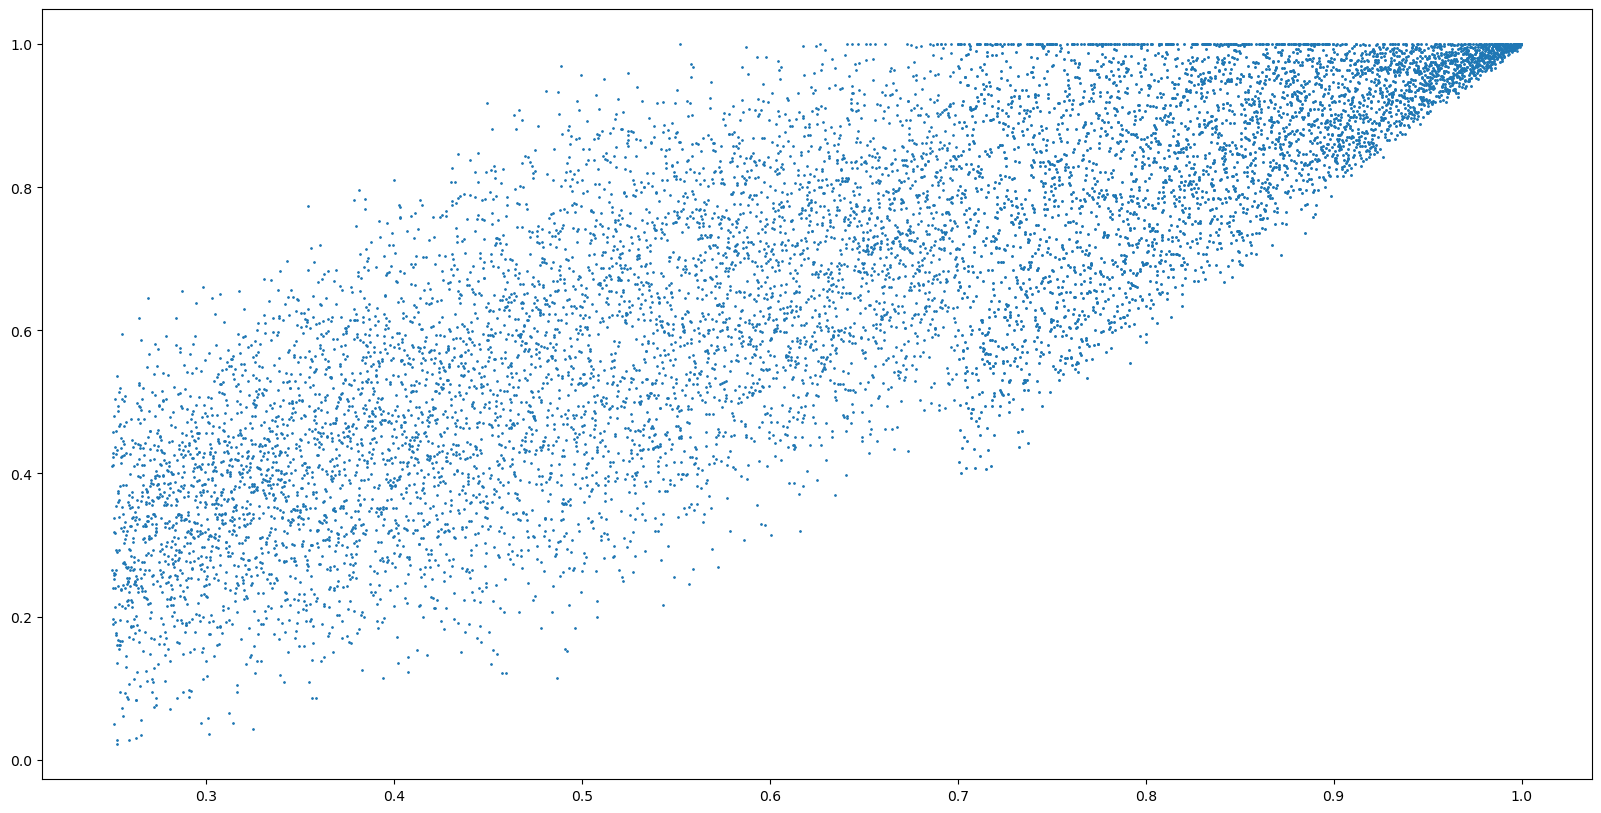

['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'collegeLevel', 'collegeScore', 'accepted']


In [166]:
# ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'collegeLevel', 'collegeScore', 'accepted']
index = 'essays'
plt.figure(figsize=(20,10))
plt.scatter(applicants[:,headers.index('percentile')], applicants[:,headers.index(index)], s=0.5)
plt.show()
print(headers)

In [160]:
for j in range(30):
    temp = {}
    for i in range(len(headers)):
        temp[headers[i]] = applicants[round(np.random.random()*applicants.shape[0]), i]
    print(temp)

{'age': 18.0, 'sex': 0.0, 'white': 0.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 0.0, 'otherRace': 0.0, 'gpa': 4.927659214184719, 'SAT': 1514.1631003774921, 'SATWriting': 5.045097994812486, 'APTests': 1.0, 'APScores': 4.394015413436156, 'STEM': 0.0, 'essays': 0.6577786013119369, 'extracurriculars': 0.5296082144479788, 'percentile': 0.7389511048895111, 'var_0': 0.6697161475281664, 'var_1': 0.774579031052508, 'var_2': 0.9258259367950153, 'var_3': 0.1942009716683636, 'var_4': 0.8128984031780412, 'var_5': 0.7422431930552155, 'var_6': 0.9527892596694292, 'collegeLevel': 2.0, 'collegeScore': 564.1555588761471, 'accepted': 1.0}
{'age': 17.0, 'sex': 1.0, 'white': 1.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 0.0, 'otherRace': 0.0, 'gpa': 3.669018547243778, 'SAT': 1600.0, 'SATWriting': 3.302091475116457, 'APTests': 0.0, 'APScores': 3.531351922794809, 'STEM': 0.0, 'essays': 0.5120421966714235, 'extracurriculars': 8.953317183086138, 'percentile': 0.7829717028297171, 'var_0': 0.9081335327251032, 'va

In [169]:
# headers_final = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'collegeLevel', 'collegeScore', 'accepted']
df = pd.DataFrame(applicants, columns=headers)
df.to_csv("college_acceptance_"+ str(n) +"_gaussian.csv")